In [1]:
import argparse
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Compose
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

In [2]:
margin_width = 50
caption_height = 60
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_vitb14').to(DEVICE).eval()
total_params = sum(param.numel() for param in depth_anything.parameters())
print('Total parameters: {:.2f}M'.format(total_params / 1e6))

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

Total parameters: 97.47M


In [3]:
# Define the image path
image_path = '/home/ilari/Downloads/dataset-corridor4_512_16/dso/cam0/images/1520621179737066985.png'

raw_image = cv2.imread(image_path)
print(f"Original size: {raw_image.shape}")
image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0
image = transform({'image': image})['image']
print(f"Transformed size: {image.shape}")

# Create a batch of size N=5
N = 20
batched_images = np.stack([image] * N)
b, c, h, w = batched_images.shape
batched_images = torch.from_numpy(batched_images).to(DEVICE)
print(f"Batched size: {batched_images.shape}")

with torch.no_grad():
    depth = depth_anything(batched_images)
print(depth.shape)
depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0

Original size: (512, 512, 3)
Transformed size: (3, 518, 518)
Batched size: torch.Size([20, 3, 518, 518])
torch.Size([20, 518, 518])


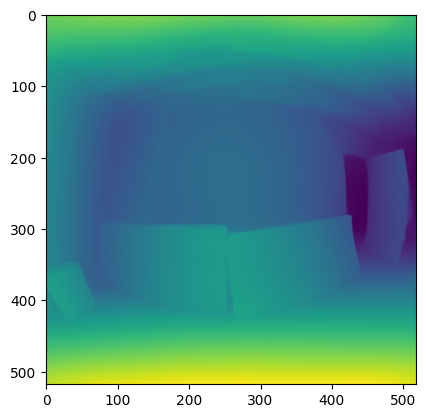

In [4]:
plt.imshow(depth.cpu().numpy())